In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

In [2]:
import random

import deeptrack as dt
import deeptrack.extras
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

deeptrack.extras.datasets.load("3DTracking")
video = scipy.io.loadmat(r"./datasets/3DTracking/1Every1_2_movie_1.aviProcessedField0.mat")
holotraces = scipy.io.loadmat(r"./datasets/3DTracking/1Every1_2_movie_1.aviCompletedTraces")
mapping = scipy.io.loadmat(r"./datasets/3DTracking/mapping.mat")["Mapping"]




3DTracking already downloaded! Use force_overwrite=True to redownload the dataset.


In [101]:
import numpy as np
import matplotlib.pyplot as plt

crop_size = 128
padding = 32
wavelength = 633e-9 
pixel_size = 114e-9
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

field_propagation = dt.get_propagation_matrix(mapping.T.shape, -11e-6, pixel_size, wavelength)

In [139]:
# De-compress data stored in fourier space

processed_video = video["ProcessedField"][0]
# Transpose to account for matlab indexing
tr_mapping = np.transpose(mapping) 

vout = []
for idx, frame in enumerate(processed_video):
    
    im = np.zeros(tr_mapping.shape) * 0j
    im[tr_mapping > 0] = frame[:, 0]

    im *= field_propagation
    im = np.fft.ifft2(im)
    out = dt.AveragePooling(ksize=(2, 2)).update().resolve(im, keep_size=False)    
    vout.append(out)

    if idx > 100:
        break
    
vout = np.array(vout)

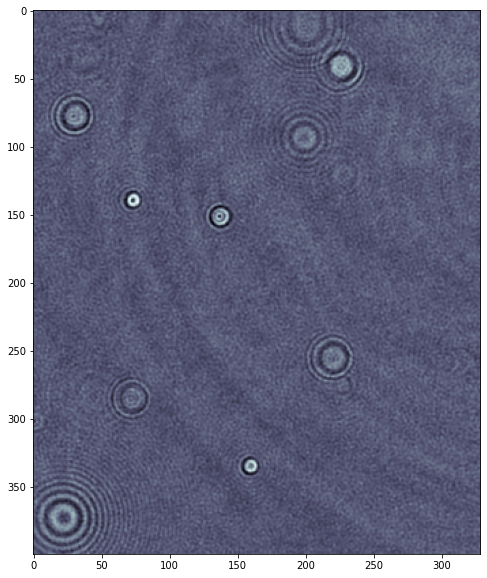

In [67]:
plt.figure(figsize=(10, 10))
plt.imshow(np.imag(vout[0, :400, 400:800]), cmap="bone")

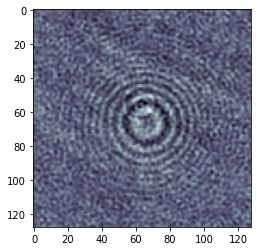

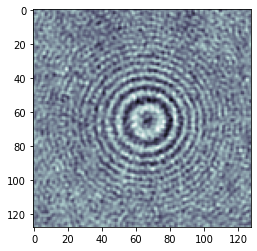

In [102]:
ds = 2
crs = 128

crops = [
    (0, 655, 445),
    (0, int(175*3/2) + 12 - 32, int(50*3/2) + 13 - 32),
    
]

training_images = []

for t, x, y in crops:
    im = vout[t, x:x+crs, y:y+crs]
    im = np.stack((np.real(im), np.imag(im)), axis=-1)
    training_images.append(im)
    plt.imshow(im[..., 1])
    plt.show()


In [128]:
args = dt.Arguments(
    translate=lambda: np.random.randn(2) * 1,
    rotate=lambda:np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randint(-20, 160),
    rescale=lambda: 10**np.random.uniform(-1, 0.5)
)

group = ( 
     dt.Affine(rotate=args.rotate) 
    >>dt.Affine(translate=args.translate) 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.005)
    >> dt.Rescale(args.rescale) 
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
    
)
group = group[16:-16, 16:-16]
equivariance = (
    dt.models.autotracking.TranslationalEquivariance(args.translate)
    >> dt.models.autotracking.Rotational2DEquivariance(args.rotate)
    >> dt.models.autotracking.Equivariance(1, args.z / 10, indexes=2)
)




In [129]:
import random
training_set = dt.Value(lambda: random.choice(training_images)) 

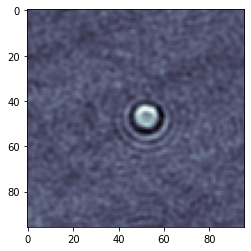

In [130]:
x = (training_set >> group).update()()
plt.imshow(x[..., 1])

In [131]:
generator = dt.models.autotracking.AutoTrackGenerator(
    training_set,
    3, 
    (group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201
)

In [132]:

with generator:
    model = dt.models.AutoMultiTracker(input_shape=(None, None, 2), num_outputs=3)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    model.fit(generator, epochs=100, steps_per_epoch=100)


Generating 201 / 200 samples before starting training
Epoch 1/100
100/100 [==============================] - 3s 12ms/step - total_loss: 5.6257 - consistency_loss: 3.7468
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - total_loss: 5.3308 - consistency_loss: 3.3957
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - total_loss: 4.9492 - consistency_loss: 2.9179
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - total_loss: 5.3348 - consistency_loss: 3.0948
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - total_loss: 4.4791 - consistency_loss: 2.3304
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - total_loss: 4.2512 - consistency_loss: 1.9886
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - total_loss: 3.0804 - consistency_loss: 0.8613
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - total_loss: 2.5775 - consistency_loss: 0.4574
Epoch 9/100
100/100 [

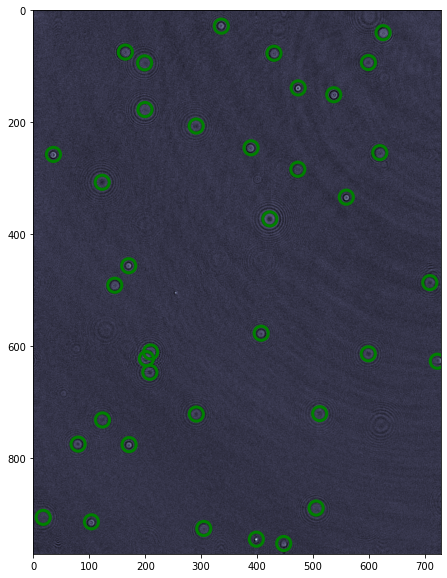

In [140]:

xvout = np.stack((np.real(vout), np.imag(vout)),axis=-1)
dets = model.predict_and_detect(xvout, alpha=0.9, beta=0.1, cutoff=0.1, mode="constant")

plt.figure(figsize=(10, 10))

plt.imshow(xvout[0, ..., 1], cmap="bone")
plt.scatter(dets[0][:, 1], dets[0][:, 0], s=200, facecolor="none", linewidths=3, edgecolors="g")
plt.show()


In [141]:

traces = []
for idx in range(len(dets)):

    connections = []
    connected_observations = []
    # Trace doroplets
    for idy, trace in enumerate(traces):

        last_frame, *pos = trace[-1]
        if idx - last_frame > 4:
            continue

        for idz, new_pos in enumerate(dets[idx]):
            distance = np.sqrt(np.square(new_pos[:2] - pos[:2]).sum())
            
            if (
                distance < 10 and idz not in connected_observations
            ):
                connected_observations.append(idz)
                trace.append(np.array((idx, *new_pos)))

    detections = [p for i, p in enumerate(dets[idx]) if i not in connected_observations]

    # Initiate new traces
    for det in detections:
        traces.append([np.array((idx, *det))])

# traces = list(filter(lambda t: len(t) > , traces))

len(traces)

403

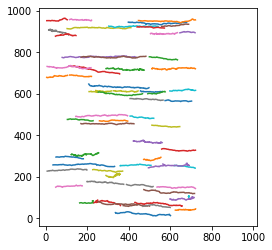

In [142]:
_traces = list(map(np.array, traces))
_traces = list(filter(lambda t: len(t) > 20, _traces))
for trace in _traces:
    plt.plot(trace[:, 2], trace[:, 1])
plt.axis("square")
plt.show()


<ipython-input-144-b3afbdd6b5ae>:14: UserWarning: linewidths is ignored by contourf
  f = ax.contourf(X, Y, val, 100, offset=0.02, linewidths=0, vmin=-0.05, vmax=0.1)


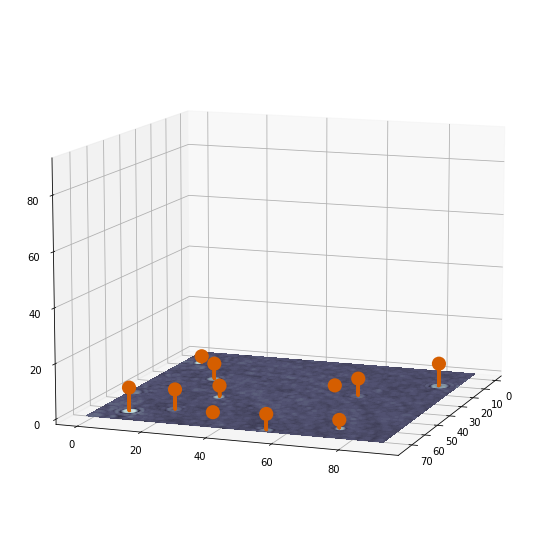

In [144]:
import seaborn
t = 30
val = dt.AveragePooling((1,1))(xvout[t, :400, 400:800, 1])
val = dt.GaussianBlur(2)(val)
# plt.set_cmap("bone")
val = np.array(val)

X, Y = np.meshgrid(np.arange(val.shape[1]) * 2 *0.114, np.arange(val.shape[0])* 2 *0.114)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection="3d")

f = ax.contourf(X, Y, val, 100, offset=0.02, linewidths=0, vmin=-0.05, vmax=0.1)

for c in f.collections:
    c.set_edgecolor("none")

detections = np.array(detections)
_dets = dets[0][dets[0][:, 0] < 400]
for _dets in _traces:
    _dets = _dets[_dets[:, 0] < t]
    _dets = _dets[:, 1:]
    if not _dets.size or _dets[-1, 1] < 400 or _dets[-1, 1] > 800 or _dets[-1, 0] > 400:
        continue
    _dets[:, 0] = _dets[:, 0] * 2 * 0.114
    _dets[:, 1] = (_dets[:, 1] - 400) * 2 * 0.114
    _dets[:, 2] = _dets[:, 2] + 0
    
    d = _dets[-1]

    ax.scatter(_dets[-1, 1], _dets[-1, 0], np.abs(_dets[-1, 2]), alpha=1, s=200, edgecolors="none", facecolors=seaborn.color_palette("colorblind")[3])
    ax.scatter([d[1]]*100, [d[0]] * 100, np.linspace(np.abs(d[2]), 0.05, 100), color=seaborn.color_palette("colorblind")[3], marker=".", alpha=1)


ax.view_init(11, 20)
# plt.xticks([])
# plt.yticks([])
ax.set_zlim(0, 400* 2 *0.114)
plt.savefig("vertical_prediction.png", dpi=200, bbox_inches="tight")

In [145]:
completed_traces = holotraces["CompletedTraces"]

all_holo_traces = []

for i in range(completed_traces.shape[1]):

    trace = completed_traces[0, i]
    trace = np.array(trace[0][0][1])
    trace[:, 0] -= 203
    trace[:, 1:3] = trace[:, 1:3] / 0.114 / 2 + 2
    all_holo_traces.append(trace)

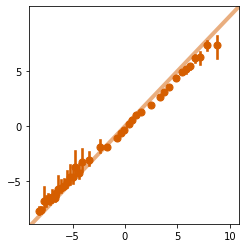

In [146]:
import scipy.spatial

z_pred = []
z_holo = []
for t in range(102):
    positions = []
    holo_pos = []
    for trace in _traces:
        x = trace[trace[:, 0] == t]
        if x.size:
            positions.append(x[0])

    for trace in all_holo_traces[:]:
        x = trace[trace[:, 0] == t]
        if x.size:
            holo_pos.append(x[0])

    positions = np.array(positions)
    holo_pos = np.array(holo_pos)
    dist = scipy.spatial.distance.cdist(positions[:, 1:3], holo_pos[:, 1:3])

    row, col = scipy.optimize.linear_sum_assignment(dist)


    costs = dist[row, col]
    mrow = row[costs < 5]
    mcol = col[costs < 5]


    for r, c in zip(mrow, mcol):
        z_pred.append(positions[r, 3])
        z_holo.append(holo_pos[c, 3])

z_pred_arr = np.array(z_pred)
z_holo_arr = np.array(z_holo)

z_pred_arr += np.mean(z_holo_arr) - np.mean(z_pred_arr)

plt.figure(figsize=(4, 4))
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
seaborn.regplot(x=z_holo_arr - 10, y=z_pred_arr - 10, ci=99, x_bins=40, truncate=False, color=seaborn.color_palette("colorblind")[3], x_ci=99, fit_reg=False)
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
plt.yticks([-5, 0, 5])
plt.axline((5, 5), (10, 10), c=seaborn.color_palette("colorblind")[3], alpha=.5, linewidth=4)
plt.savefig("z_truevsactual.svg")

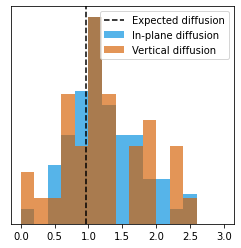

In [147]:
delta_time = all_holo_traces[0][1, 6] - all_holo_traces[0][0, 6]

def get_msd(x, max_dt=4):

    output = []
    for delt in range(max_dt):
        delta = x[1 + delt :] - x[: -(1 + delt)]
        
        th = 100 * np.sqrt(delt + 1)
        if np.any(delta > th):
            print(np.sum(delta > th))

        delta[delta > th] = 0
        squared_displacement = np.square(delta).sum(axis=-1)

        output.append(
            (
                np.mean(squared_displacement),
                np.std(squared_displacement),
                len(squared_displacement),
            )
        )

    return np.array(output)

def fit_to_line(msd):
    return np.polyfit(range(1, msd.shape[0]+1), msd[:, 0], 1)

msds = []
msds_z = []
for positions in _traces:
    positions = np.array(positions)
    positions[:, 2] -= np.arange(positions.shape[0]) * (positions[-1, 2] - positions[0, 2]) / positions.shape[0]
    
    msd = get_msd(positions[:, 1:3] * 0.114 * 2, 10) / 2
    a, b = fit_to_line(msd[:4])
    msds.append(a)

    msd = get_msd(positions[:, 3:4] * 1.5/1.33, 10)
    a, b = fit_to_line(msd[:4])
    msds_z.append(a)


plt.figure(figsize=(4, 4))
plt.hist(np.array(msds) / delta_time / 2, 15, range=(0, 3), density=True, alpha=1, facecolor=seaborn.color_palette("colorblind")[9])
plt.hist(np.array(msds_z) / delta_time / 2, 15, range=(0, 3), density=True, alpha=0.66, facecolor=seaborn.color_palette("colorblind")[3])

plt.yticks([])
plt.axvline(0.9638, c="k", linestyle="--")
plt.legend(["Expected diffusion", "In-plane diffusion", "Vertical diffusion", ])
plt.savefig("diffusion_histogram.svg")
